## Merge ASF Vertical Displacement Scenes

#### Needed: two scene pairs, one northern and one southern, that cover the entirety of the target outer banks area over the same time interval (ideally)

#### Result: single combined vertical displacement geotiff from combined scene pairs

This code will combine the two reference scenes and re-export them as a geotiff with attached metadata. The exported geotiff can then be clipped for comparison with vegetation and JABLTCX data.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import earthpy.plot as ep
import rasterio as rio
import rioxarray as rxr
from rasterio.merge import merge

/Users/tylerlogie/opt/anaconda3/envs/geostats_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# import the north and south reference scenes
# change the north and south variables for different scene folder names
north = "North_S1AA_20181008T230617_20181125T230617_VVP048_INT80_G_weF_11AE/S1AA_20181008T230617_20181125T230617_VVP048_INT80_G_weF_11AE_vert_disp.tif"
south = "South_S1AA_20181008T230552_20181125T230551_VVP048_INT80_G_weF_61C9/S1AA_20181008T230552_20181125T230551_VVP048_INT80_G_weF_61C9_vert_disp.tif"
filepath_north = "../RawData/" + north
filepath_south = "../RawData/" + south

with rio.open(filepath_south) as south_vert_disp:
    south_vert = south_vert_disp.read(1)
    south_vert_meta = south_vert_disp.profile
    south_vert_reproj, south_vert_reproj_trans = rio.warp.reproject(source=rio.band(south_vert_disp, 1),
                                               dst_crs=south_vert_disp.profile['crs'],
                                               dst_resolution=(30, 30)
                                              )
with rio.open(filepath_north) as north_vert_disp:
    north_vert= north_vert_disp.read(1)
    north_vert_meta = north_vert_disp.profile
    north_vert_reproj, north_vert_reproj_trans = rio.warp.reproject(source=rio.band(north_vert_disp, 1),
                                               dst_crs=north_vert_disp.profile['crs'],
                                               dst_resolution=(30, 30)
                                              )
print

<function print>

In [3]:
# see metadata for geotiffs. this includes size of scenes, crs, driver, and other information
print(south_vert_meta)
print(north_vert_meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 3579, 'height': 2875, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(80.0, 0.0, 212680.0,
       0.0, -80.0, 4007480.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 3563, 'height': 2785, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(80.0, 0.0, 186120.0,
       0.0, -80.0, 4173240.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.



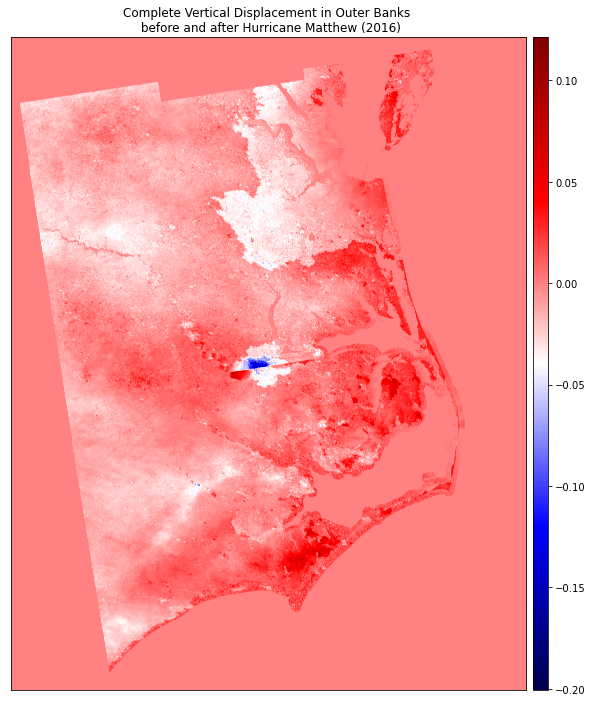

In [4]:
# create raster datasets from above transformed geotiffs

def create_dataset(data, crs, transform):
    # Receives a 2D array, a transform and a crs to create a rasterio dataset
    memfile = rio.io.MemoryFile()
    dataset = memfile.open(driver='GTiff', height=data.shape[0], width=data.shape[1], count=1, crs=crs, 
                           transform=transform, dtype=data.dtype)
    dataset.write(data, 1)
        
    return dataset

# use the above custom create_dataset functions to create new raster datasets with the reprojected rasters, crs from
# metadata, and transform (also from reprojection). this creates a new geotiff with desired height and width
south_vert_reproj_ds = create_dataset(south_vert_reproj[0], south_vert_disp.profile['crs'], south_vert_reproj_trans)
north_vert_reproj_ds = create_dataset(north_vert_reproj[0], north_vert_disp.profile['crs'], north_vert_reproj_trans)

# merge the two datasets, returning a single merged raster and the transformation used
merged, transf = merge([south_vert_reproj_ds, north_vert_reproj_ds])

# plot combined raster (note: scale bar is not centered with white as 0, but since we are further clipping this
# doesn't really matter)
ep.plot_bands(merged[0],
              title="Complete Vertical Displacement in Outer Banks \n before and after Hurricane Matthew (2016)",
              cmap="seismic")

plt.show()

In [5]:
# create the metadata for the merged file, based on the format of the original component geotiffs
merged_meta = south_vert_reproj_ds.meta.copy()

# Update the metadata with the height, width, and transformation of combined raster. all other information should hold
# steady from both of the original rasters
merged_meta.update({"driver": "GTiff",
                 "height": merged.shape[1],
                 "width": merged.shape[2],
                 "transform": transf
                }
               )
print(merged_meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 10430, 'height': 13193, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(30.0, 0.0, 186120.0,
       0.0, -30.0, 4173240.0)}


In [6]:
# now ready to save combined geotiff file. minor future issue: is there a way to save geotiff with color scheme?
out_file = "../RawData/10_08_to_11_25_combined.tif"
# if there is already a file with this name, delete and resave the new file
if os.path.isfile(out_file):
    os.remove(out_file)
# write the geotiff file with relavent metadata using rio.open
with rio.open(out_file, "w", **merged_meta) as dest:
        dest.write(merged)

There should now be a geotiff with the chosen out_file name in the RawData folder. In the future, we can improve the workflow with better directory management so it's cleaner